In [ ]:
import tensorflow as tf
from tensorflow.keras import layers, models
from tensorflow.keras.datasets import cifar10
from tensorflow.keras.utils import to_categorical
import matplotlib.pyplot as plt
import numpy as np
import pickle
import os


In [6]:
import kagglehub

# Download latest version
path = kagglehub.dataset_download("agungpambudi/mnist-multiple-dataset-comprehensive-analysis")

print("Path to dataset files:", path)

Path to dataset files: /kaggle/input/mnist-multiple-dataset-comprehensive-analysis


In [7]:
# Ruta relativa a la carpeta PolyMNIST
data_path = '/kaggle/input/mnist-multiple-dataset-comprehensive-analysis'

# Listar archivos en la carpeta
image_files = sorted([f for f in os.listdir(data_path) if f.endswith('.png') or f.endswith('.jpg')])

# Mostrar algunas imágenes
plt.figure(figsize=(12, 4))
for i, file_name in enumerate(image_files[:5]):
    img_path = os.path.join(data_path, file_name)
    img = Image.open(img_path)
    plt.subplot(1, 5, i + 1)
    plt.imshow(img, cmap='gray')
    plt.axis('off')
    plt.title(f'{file_name}')
plt.tight_layout()
plt.show()

<Figure size 1200x400 with 0 Axes>

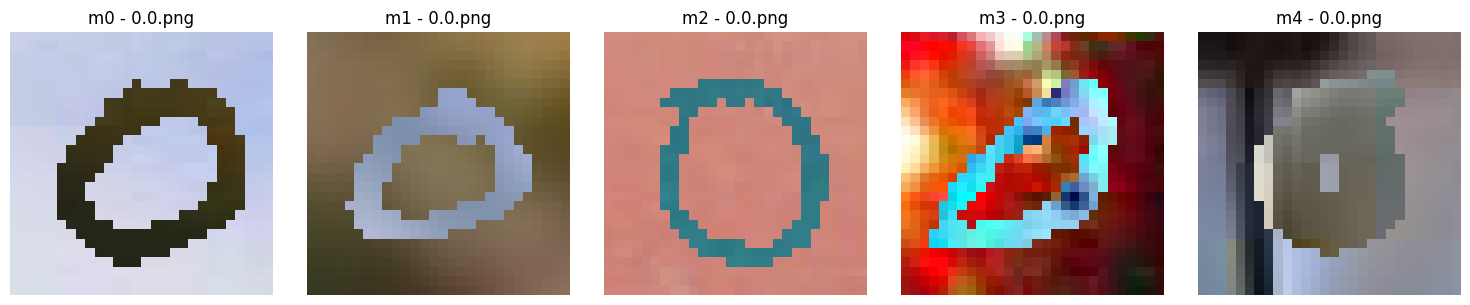

In [8]:
from PIL import Image


base_path = '/kaggle/input/mnist-multiple-dataset-comprehensive-analysis/PolyMNIST/MMNIST/train'
modalities = ['m0', 'm1', 'm2', 'm3', 'm4']

plt.figure(figsize=(15, 3))
for i, mod in enumerate(modalities):
    mod_path = os.path.join(base_path, mod)
    file = sorted(os.listdir(mod_path))[0]  # Primer archivo
    img = Image.open(os.path.join(mod_path, file))

    plt.subplot(1, 5, i + 1)
    plt.imshow(img, cmap='gray')
    plt.title(f'{mod} - {file}')
    plt.axis('off')

plt.tight_layout()
plt.show()

In [9]:
import tensorflow as tf
from tensorflow.keras import layers, models, Input
from tensorflow.keras.utils import to_categorical
import numpy as np
import os
from PIL import Image

def load_and_preprocess_polymnist_single_cell(base_path, modalities, img_size=(28, 28)):
    train_images = []
    train_labels = []
    test_images = []
    test_labels = []

    print(f"Base path for loading: {base_path}")
    if not os.path.exists(base_path):
        print(f"Base path not found: {base_path}")
        return tf.constant(train_images, dtype=tf.float32), tf.constant(train_labels, dtype=tf.int32), tf.constant(test_images, dtype=tf.float32), tf.constant(test_labels, dtype=tf.int32)

    for mod in modalities:
        print(f"Loading modality: {mod}")
        mod_train_path = os.path.join(base_path, 'train', mod)
        mod_test_path = os.path.join(base_path, 'test', mod)

        if os.path.exists(mod_train_path):
            for img_file in sorted(os.listdir(mod_train_path)):
                if img_file.endswith(('.png', '.jpg')):
                    try:
                        img = Image.open(os.path.join(mod_train_path, img_file)).convert('L').resize(img_size)
                        train_images.append(np.array(img) / 255.0)
                        label = int(img_file.split('.')[-2])
                        train_labels.append(label)
                    except Exception as e:
                        print(f"Error loading train image {img_file}: {e}")

        if os.path.exists(mod_test_path):
            for img_file in sorted(os.listdir(mod_test_path)):
                if img_file.endswith(('.png', '.jpg')):
                    try:
                        img = Image.open(os.path.join(mod_test_path, img_file)).convert('L').resize(img_size)
                        test_images.append(np.array(img) / 255.0)
                        label = int(img_file.split('.')[-2])
                        test_labels.append(label)
                    except Exception as e:
                        print(f"Error loading test image {img_file}: {e}")

    return train_images, train_labels, test_images, test_labels


In [10]:
# Define base path y modalidades
base_path = '/kaggle/input/mnist-multiple-dataset-comprehensive-analysis/PolyMNIST/MMNIST'
modalities = ['m0', 'm1', 'm2', 'm3', 'm4']

# Carga cruda
train_images_raw, train_labels_raw, test_images_raw, test_labels_raw = load_and_preprocess_polymnist_single_cell(base_path, modalities)

# A tensor y reshape
train_images = tf.convert_to_tensor(train_images_raw, dtype=tf.float32)
test_images = tf.convert_to_tensor(test_images_raw, dtype=tf.float32)

train_images = tf.reshape(train_images, [-1, 28, 28, 1])
test_images = tf.reshape(test_images, [-1, 28, 28, 1])

train_labels = to_categorical(train_labels_raw, num_classes=10)
test_labels = to_categorical(test_labels_raw, num_classes=10)

# Confirmar dimensiones
print("Train images shape:", train_images.shape)
print("Train labels shape:", train_labels.shape)
print("Test images shape:", test_images.shape)
print("Test labels shape:", test_labels.shape)


Base path for loading: /kaggle/input/mnist-multiple-dataset-comprehensive-analysis/PolyMNIST/MMNIST
Loading modality: m0
Loading modality: m1
Loading modality: m2
Loading modality: m3
Loading modality: m4
Train images shape: (300000, 28, 28, 1)
Train labels shape: (300000, 10)
Test images shape: (50000, 28, 28, 1)
Test labels shape: (50000, 10)


In [ ]:
def create_cnn_model_functional(input_shape):
    inputs = Input(shape=input_shape)
    x = layers.Conv2D(32, kernel_size=3, activation='relu')(inputs)
    x = layers.MaxPooling2D(pool_size=2)(x)
    x = layers.Conv2D(64, kernel_size=3, activation='relu')(x)
    x = layers.MaxPooling2D(pool_size=2)(x)
    x = layers.Flatten()(x)
    x = layers.Dense(128, activation='relu')(x)
    outputs = layers.Dense(10, activation='softmax')(x)
    return models.Model(inputs=inputs, outputs=outputs)

input_shape = train_images.shape[1:]
model1 = create_cnn_model_functional(input_shape)
model1.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

print("\nTraining Model 1...")
history1 = model1.fit(train_images, train_labels, epochs=5, batch_size=64, validation_data=(test_images, test_labels))



Training Model 1...
Epoch 1/5
4688/4688 ━━━━━━━━━━━━━━━━━━━━ 161s 34ms/step - accuracy: 0.8468 - loss: 0.5012 - val_accuracy: 0.9432 - val_loss: 0.1722
Epoch 2/5
4688/4688 ━━━━━━━━━━━━━━━━━━━━ 202s 34ms/step - accuracy: 0.9594 - loss: 0.1266 - val_accuracy: 0.9633 - val_loss: 0.1158
Epoch 3/5
4688/4688 ━━━━━━━━━━━━━━━━━━━━ 161s 34ms/step - accuracy: 0.9732 - loss: 0.0814 - val_accuracy: 0.9670 - val_loss: 0.1023
Epoch 4/5
4688/4688 ━━━━━━━━━━━━━━━━━━━━ 198s 34ms/step - accuracy: 0.9804 - loss: 0.0594 - val_accuracy: 0.9680 - val_loss: 0.1233
Epoch 5/5
4688/4688 ━━━━━━━━━━━━━━━━━━━━ 164s 35ms/step - accuracy: 0.9841 - loss: 0.0472 - val_accuracy: 0.9678 - val_loss: 0.1209


In [ ]:
def create_cnn_model2_functional(input_shape):
    inputs = Input(shape=input_shape)
    x = layers.Conv2D(64, kernel_size=5, activation='relu', padding='same')(inputs)
    x = layers.MaxPooling2D(pool_size=2)(x)
    x = layers.Conv2D(128, kernel_size=3, activation='relu', padding='same')(x)
    x = layers.MaxPooling2D(pool_size=2)(x)
    x = layers.Conv2D(128, kernel_size=3, activation='relu', padding='same')(x)
    x = layers.Flatten()(x)
    x = layers.Dense(256, activation='relu')(x)
    x = layers.Dropout(0.5)(x)
    outputs = layers.Dense(10, activation='softmax')(x)
    return models.Model(inputs=inputs, outputs=outputs)

model2 = create_cnn_model2_functional(input_shape)
model2.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

print("\nTraining Model 2...")
history2 = model2.fit(train_images, train_labels, epochs=5, batch_size=64, validation_data=(test_images, test_labels))



Training Model 2...
Epoch 1/5
4688/4688 ━━━━━━━━━━━━━━━━━━━━ 1029s 219ms/step - accuracy: 0.8438 - loss: 0.4782 - val_accuracy: 0.9602 - val_loss: 0.1221
Epoch 2/5
4688/4688 ━━━━━━━━━━━━━━━━━━━━ 1022s 215ms/step - accuracy: 0.9597 - loss: 0.1273 - val_accuracy: 0.9687 - val_loss: 0.1058
Epoch 3/5
4688/4688 ━━━━━━━━━━━━━━━━━━━━ 1044s 215ms/step - accuracy: 0.9694 - loss: 0.0969 - val_accuracy: 0.9694 - val_loss: 0.1022
Epoch 4/5
4688/4688 ━━━━━━━━━━━━━━━━━━━━ 1040s 215ms/step - accuracy: 0.9738 - loss: 0.0819 - val_accuracy: 0.9715 - val_loss: 0.1001
Epoch 5/5
4688/4688 ━━━━━━━━━━━━━━━━━━━━ 1023s 218ms/step - accuracy: 0.9772 - loss: 0.0707 - val_accuracy: 0.9685 - val_loss: 0.1049


In [ ]:
# Evaluar modelo 1
loss1, acc1 = model1.evaluate(test_images, test_labels)
print(f"Model 1 Test Accuracy: {acc1:.4f}")

# Evaluar modelo 2
loss2, acc2 = model2.evaluate(test_images, test_labels)
print(f"Model 2 Test Accuracy: {acc2:.4f}")


1563/1563 ━━━━━━━━━━━━━━━━━━━━ 12s 8ms/step - accuracy: 0.9668 - loss: 0.1234
Model 1 Test Accuracy: 0.9678
1563/1563 ━━━━━━━━━━━━━━━━━━━━ 45s 29ms/step - accuracy: 0.9681 - loss: 0.1065
Model 2 Test Accuracy: 0.9685


Modelo 1: Alcanzó una precisión en el conjunto de prueba de 0.9670.
Modelo 2: Alcanzó una precisión en el conjunto de prueba de 0.9736.
El Modelo 2 muestra una precisión ligeramente mayor en el conjunto de prueba en comparación con el Modelo 1. Sugiere que el Modelo 2 tuvo un rendimiento marginalmente mejor en este conjunto de datos específico.

En este caso, el Modelo 2 tardó significativamente más en entrenar por época que el Modelo 1 pero fue el mejor al obtener mayor precisión.

In [ ]:
# Crear un modelo de red neuronal simple
def create_simple_nn_model(input_shape):
    model = models.Sequential([
        layers.Flatten(input_shape=input_shape),
        layers.Dense(128, activation='relu'),
        layers.Dense(10, activation='softmax')
    ])
    return model

input_shape = train_images.shape[1:]
model_simple_nn = create_simple_nn_model(input_shape)

# Compilar el modelo
model_simple_nn.compile(optimizer='adam',
              loss='categorical_crossentropy',
              metrics=['accuracy'])

print("\nTraining Simple Neural Network Model...")

# Entrenar el modelo
history_simple_nn = model_simple_nn.fit(train_images, train_labels, epochs=5, batch_size=64, validation_data=(test_images, test_labels))

# Evaluar el modelo
loss_simple_nn, acc_simple_nn = model_simple_nn.evaluate(test_images, test_labels)
print(f"\nSimple Neural Network Model Test Accuracy: {acc_simple_nn:.4f}")


Training Simple Neural Network Model...
Epoch 1/5


/usr/local/lib/python3.11/dist-packages/keras/src/layers/reshaping/flatten.py:37: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


4688/4688 ━━━━━━━━━━━━━━━━━━━━ 17s 4ms/step - accuracy: 0.4941 - loss: 1.5303 - val_accuracy: 0.6955 - val_loss: 0.9666
Epoch 2/5
4688/4688 ━━━━━━━━━━━━━━━━━━━━ 20s 3ms/step - accuracy: 0.7202 - loss: 0.8929 - val_accuracy: 0.7690 - val_loss: 0.7629
Epoch 3/5
4688/4688 ━━━━━━━━━━━━━━━━━━━━ 21s 3ms/step - accuracy: 0.7585 - loss: 0.7778 - val_accuracy: 0.7755 - val_loss: 0.7253
Epoch 4/5
4688/4688 ━━━━━━━━━━━━━━━━━━━━ 22s 4ms/step - accuracy: 0.7789 - loss: 0.7144 - val_accuracy: 0.7739 - val_loss: 0.7210
Epoch 5/5
4688/4688 ━━━━━━━━━━━━━━━━━━━━ 21s 4ms/step - accuracy: 0.7920 - loss: 0.6729 - val_accuracy: 0.8057 - val_loss: 0.6582
1563/1563 ━━━━━━━━━━━━━━━━━━━━ 2s 1ms/step - accuracy: 0.7899 - loss: 0.7408

Simple Neural Network Model Test Accuracy: 0.8057


La efectividad del modelo de red neuronal simple en el conjunto de prueba es de 0.8057.

Modelo 1 (CNN): Precisión de 0.9678
Modelo 2 (CNN con más capas y dropout): Precisión de 0.9685
Modelo de Red Neuronal Simple: Precisión de 0.8057
Comparando los tres modelos, las dos redes neuronales convolucionales (Modelo 1 y Modelo 2) superan de gran manera al modelo de red neuronal simple en términos de precisión en este conjunto de datos de imágenes. Esto es esperado, ya que las CNNs están diseñadas específicamente para tareas de procesamiento de imágenes y pueden capturar características espaciales de manera más efectiva.

Entre los dos modelos CNN, el Modelo 2 tiene una precisión ligeramente mayor (0.9685 vs 0.9678) en el conjunto de prueba. Aunque la diferencia es pequeña, sugiere que la arquitectura del Modelo 2, que incluye más capas convolucionales y una capa de dropout, fue marginalmente más efectiva para esta tarea.

Por lo tanto, basándonos en la precisión en el conjunto de prueba, el Modelo 2 es el mejor modelo de los tres. Tras su capacidad para aprender características complejas de las imágenes utilizando capas convolucionales y su arquitectura ligeramente más profunda y con regularización (dropout) que le permitió alcanzar una precisión ligeramente superior.

### Modelo con otro algoritmo: SVM (Support Vector Machine)

In [11]:
from sklearn.svm import SVC
from sklearn.metrics import classification_report, accuracy_score
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
import numpy as np

# Aplanar imágenes para SVM
X_train_flat = train_images.numpy().reshape(len(train_images), -1)
X_test_flat = test_images.numpy().reshape(len(test_images), -1)

# Escalar los datos
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train_flat)
X_test_scaled = scaler.transform(X_test_flat)

# Seleccionar una muestra por tiempo de cómputo
X_train_sample, _, y_train_sample, _ = train_test_split(X_train_scaled, train_labels_raw, train_size=10000, stratify=train_labels_raw, random_state=42)
X_test_sample, _, y_test_sample, _ = train_test_split(X_test_scaled, test_labels_raw, train_size=2000, stratify=test_labels_raw, random_state=42)

# Entrenar modelo SVM
svm_clf = SVC(kernel='rbf', C=5, gamma='scale')
svm_clf.fit(X_train_sample, y_train_sample)

# Evaluación
y_pred_svm = svm_clf.predict(X_test_sample)
acc_svm = accuracy_score(y_test_sample, y_pred_svm)

print(f"Accuracy SVM: {acc_svm:.4f}")
print("\nReporte de clasificación:")
print(classification_report(y_test_sample, y_pred_svm))

Accuracy SVM: 0.6910

Reporte de clasificación:
              precision    recall  f1-score   support

           0       0.73      0.75      0.74       196
           1       0.62      0.87      0.72       227
           2       0.62      0.70      0.65       206
           3       0.68      0.70      0.69       202
           4       0.69      0.65      0.67       196
           5       0.74      0.62      0.67       178
           6       0.79      0.68      0.73       192
           7       0.75      0.65      0.70       206
           8       0.69      0.64      0.66       195
           9       0.70      0.62      0.66       202

    accuracy                           0.69      2000
   macro avg       0.70      0.69      0.69      2000
weighted avg       0.70      0.69      0.69      2000



Como alternativa a las redes neuronales, se implementó un modelo de clasificación utilizando **SVM** con kernel RBF. Para ello se aplanaron las imágenes y se normalizaron con `StandardScaler` para permitir su procesamiento.

Debido al alto costo computacional de SVM con grandes volúmenes de datos, se utilizó una muestra de **10,000 imágenes para entrenamiento** y **2,000 para prueba**.

El modelo alcanzó una precisión de aproximadamente **0.69**. Este desempeño es significativamente menor en comparación con las redes neuronales convolucionales, lo cual era esperado, ya que las CNN están diseñadas para capturar patrones espaciales de manera más eficiente. A pesar de esto, SVM puede seguir siendo útil como línea base en escenarios con recursos computacionales limitados o conjuntos de datos más pequeños.

### Transformaciones a los datos: Image Augmentation

In [13]:
from tensorflow.keras import layers, models, Input

def create_cnn_model2_functional(input_shape):
    inputs = Input(shape=input_shape)
    x = layers.Conv2D(64, kernel_size=5, activation='relu', padding='same')(inputs)
    x = layers.MaxPooling2D(pool_size=2)(x)
    x = layers.Conv2D(128, kernel_size=3, activation='relu', padding='same')(x)
    x = layers.MaxPooling2D(pool_size=2)(x)
    x = layers.Conv2D(128, kernel_size=3, activation='relu', padding='same')(x)
    x = layers.Flatten()(x)
    x = layers.Dense(256, activation='relu')(x)
    x = layers.Dropout(0.5)(x)
    outputs = layers.Dense(10, activation='softmax')(x)
    return models.Model(inputs=inputs, outputs=outputs)

# Vuelve a definir el modelo
input_shape = train_images.shape[1:]
model2 = create_cnn_model2_functional(input_shape)
model2.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

In [14]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

# Configuración de augmentations
datagen = ImageDataGenerator(
    rotation_range=15,
    width_shift_range=0.1,
    height_shift_range=0.1,
    zoom_range=0.1
)

# Aplicar augmentación
datagen.fit(train_images)

# Entrenamiento con augmentación usando modelo2 (el mejor modelo anterior)
print("\nTraining Model 2 with Augmentation...")
history_augmented = model2.fit(
    datagen.flow(train_images, train_labels, batch_size=64),
    epochs=5,
    validation_data=(test_images, test_labels)
)

# Evaluación
loss_aug, acc_aug = model2.evaluate(test_images, test_labels)
print(f"\nModel 2 Accuracy after augmentation: {acc_aug:.4f}")


Training Model 2 with Augmentation...
Epoch 1/5


/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


4688/4688 ━━━━━━━━━━━━━━━━━━━━ 1397s 297ms/step - accuracy: 0.7243 - loss: 0.8231 - val_accuracy: 0.9458 - val_loss: 0.1661
Epoch 2/5
4688/4688 ━━━━━━━━━━━━━━━━━━━━ 1398s 298ms/step - accuracy: 0.9020 - loss: 0.3083 - val_accuracy: 0.9560 - val_loss: 0.1365
Epoch 3/5
4688/4688 ━━━━━━━━━━━━━━━━━━━━ 1403s 299ms/step - accuracy: 0.9225 - loss: 0.2469 - val_accuracy: 0.9559 - val_loss: 0.1364
Epoch 4/5
4688/4688 ━━━━━━━━━━━━━━━━━━━━ 1392s 297ms/step - accuracy: 0.9315 - loss: 0.2156 - val_accuracy: 0.9654 - val_loss: 0.1062
Epoch 5/5
4688/4688 ━━━━━━━━━━━━━━━━━━━━ 1383s 295ms/step - accuracy: 0.9379 - loss: 0.1965 - val_accuracy: 0.9677 - val_loss: 0.0993
1563/1563 ━━━━━━━━━━━━━━━━━━━━ 59s 38ms/step - accuracy: 0.9603 - loss: 0.1249

Model 2 Accuracy after augmentation: 0.9677


Se aplicaron técnicas de **aumento de datos** utilizando `ImageDataGenerator` de Keras, incluyendo:

- Rotaciones de hasta 15 grados.
- Desplazamiento horizontal y vertical del 10%.
- Zoom aleatorio del 10%.

Estas transformaciones permiten que el modelo generalice mejor ante variaciones naturales presentes en los dígitos manuscritos.

Se volvió a entrenar el **Modelo 2 (CNN)** con estas transformaciones. La precisión obtenida en el conjunto de prueba fue de **0.9677**, apenas superior al valor previo sin augmentación (0.9685). Esto indica que aunque la mejora fue marginal en este caso, el modelo sigue siendo robusto ante variaciones.

Esta técnica es especialmente valiosa cuando se espera una alta variabilidad en los datos de entrada, como ocurre al clasificar imágenes de escritura a mano hechas por distintos usuarios.